# Analyzing Association in Babylonian Zodiacal Medical Ingredients

M. Willis Monroe (AOS 2017, Los Angeles)

The use of the zodiac in diverse forms of scribal knowledge in the Late Babylonian period
allowed scholars to approach and organize traditional texts in new ways. From calendrical to medical
material, the zodiacal schemes could be applied to a range of text genres. The coupling of zodiacal
signs and medical ingredients, for example, offered an opportunity to link celestial signs and earthly
objects. This paper will investigate the connections between the signs of the zodiac and medical
ingredients in Late Babylonian texts.

The principal corpus from which to draw out these connections is the Micro-zodiac tables from
Uruk and Babylon, which contain a wide range of information connected to a complicated scheme of
zodiacal sign pairs. Unlike other rows on the table which have prior textual traditions with which to
compare logical structure, the medical ingredients and their connection to the zodiacal signs must be
analyzed in their local context by bringing in comparisons with other contemporary texts which use
both signs of the zodiac and medical ingredients. Some of these contemporary texts are closely related
to the Micro-zodiac in structures, while others represent disparate traditions but still make use of
zodiacal signs and medical ingredients.

This study makes use of modern text processing techniques to compute the relative distance
between the groupings of medical ingredients in an effort to understand the logic behind their
association with certain zodiacal signs. The zodiacal scheme, as mentioned above, is complex and the
connection between sign and ingredient is not straight forward. This study will analyze texts across
genre and provenance in order to elucidate whether the pattern of association was based on the type or
origin of the text.

The first part of this notebook involves importing the relevant libraries (Pandas, Seaborn, and parts of SciKit-learn and NLTK).  Then a few configurations are changed, surpressing warnings, and setting the font for the graphs.

In [2]:
# Initial setup and importing of useful libraries:
# Inline graphs
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.metrics import edit_distance
from itertools import combinations

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Set the font for graphs
sns.set(font='Brill', font_scale=1.75)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:880: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The next four functions are all helper functions written in order to assist in processing the data.  They're relatively specific to the data I'm working with but can either be adapted to other forms of data, or serve as a rough guideline for how to process other formats.  The first three functions should be called in order to produce an adjacency matrix and output it to CSV in order to graph it with Gephi.  The final function is just a utility for looking for possibles user entered errors in the data, it doesn't work particularly well but is a useful quick check.

In [3]:
def make_bags(in_df, index='ID', content='name only'):
    # Input is a DataFrame with at least two columns.
    # Output is a Pandas DataFrame with the index equal to 'ID' and the content
    # as a comma separated list of items from the "name only" column.
    bags_of_ingredients = []
    for cell in in_df[index].unique():
        bag = ','.join(in_df[in_df[index] == cell][content])
        bags_of_ingredients.append((cell, bag))
        
    df_bags = pd.DataFrame(bags_of_ingredients, columns=['cell','items'])
    df_bags = df_bags.set_index('cell')
        
    return df_bags

In [4]:
def get_adjacency_matrix(in_df):
    # Input is a dataframe from the make_bags function.
    # Output is an adjacency matrix where each row of the Dataframe
    # is compared linearly with each other row giving an integer for
    # their direct similarity, i.e. 1 equals one item in common,
    # 2 equals 2 items etc... 
    vec = CountVectorizer(analyzer='word', token_pattern=r'[^,]+')
    dtm = vec.fit_transform(df_bags['items'])
    df_dtm = pd.DataFrame(dtm.toarray(), columns=vec.get_feature_names(), index=df_bags.index.values)
    df_dtm.head(1)
    return linear_kernel(df_dtm)

In [5]:
def write_adjacency_matrix_as_csv(in_df, a_matrix, filename):
    # Input is: a dataframe from the make_bags function,
    # an adjacency matrix from the get_adjacency_matrix function,
    # and a filename to write the resulting csv to.
    with open(filename,"w") as f:
        line = ';'
        for item in in_df.index:
            line += item + ';'
        f.write(line + "\n")
        for row in zip(in_df.index,a_matrix):
            line = row[0] + ';'
            line += ';'.join([str(x) for x in row[1]])
            #for item in row:
            #    line += (str(item) + ",")
            f.write(line + "\n")

In [6]:
def find_poss_errors(in_df, column='name only', max_dist=4, first_letter=True):
    # Input is a dataframe, optional parameters include the column to analyze
    # and the maximum distance between items analyzed.  This function assumes
    # that the first letter is correct, that can be turned off with first_letter=False.
    all_combos = list(combinations(in_df[column], 2))
    combos = []
    for combo in all_combos:
        #generally the first letter is correct
        if combo[0][0] != combo[1][0] and first_letter:
            continue
        dist = edit_distance(combo[0], combo[1])
        if 0 < dist < max_dist:
            combos.append((combo, dist))
    return sorted(combos, key=lambda x: x[1])

This next cell contains the main processing with Pandas to get the data from a CSV file I created into a number of useful Pandas DataFrame for further analysis.  It starts by importing the raw DataFrame and then filling all missing values with '0'.  Next it filters to get rid of any rows where the 'name only' field is 0, because those rows are not useful for this analysis.  Then two new columns are added by combining existing columns, these are purely for convenience and make later processing easier.  Finally, I go through the data looking for any rows where the 'name only' field consists of only x's '.'s or spaces, as those would give many false positives.  In the end I convert this cleaned DataFrame into two, one for just the Micro-zodiac and one for the Micro-zodiac and the Calendar texts.

In [7]:
# Start by importing a manually coded csv of the texts
ingredients = pd.read_csv("Zodiac Ingredients - Sheet1.csv")
ingredients.fillna(value="0", inplace=True)
# Get rid of the rows with 0 in the name field
ingredients = ingredients[ingredients['name only'] != '0']
# Create a new column (ID) with the format "#Text / Majorsign-minorsign"
ingredients['ID'] = '#' + ingredients['text'].map(str) + "/" + ingredients['zodiacal location']
# Create a new column (name_and_type) which combines the 'name only' field and its type.
ingredients['name_and_type'] = ingredients['name only'] + ' (' + ingredients['type'] + ")"
# Get rid of any rows where 'name only' is only made up up x's or '.'s
cleaned_ingredients = ingredients[ingredients['name only'].str.match('^[x .]+$') == False]
mz_ingredients = cleaned_ingredients[cleaned_ingredients['text_type'] == 'Micro-zodiac']
ct_ingredients = cleaned_ingredients[cleaned_ingredients['text_type'] == 'Calendar-text']

This cell shows how to use the helper functions defined above to take two different DataFrames run them through the analysis and write out the CSV files for use by Gephi.

In [8]:
# Write out adjacency for different groupings of ingredients
datasets = [('MZ', mz_ingredients), 
            ('MZ_and_CT', cleaned_ingredients)]
for dataset in datasets:
    name = dataset[0]
    df = dataset[1]
    df_bags = make_bags(df)
    df_dtm = get_adjacency_matrix(df_bags)
    write_adjacency_matrix_as_csv(df_bags, df_dtm, '{}-dist.csv'.format(name))

# Graphing

At this point, with the CSVs created, we can now import them into Gephi for analysis.  Because they're adjacency matrices the only way to import them successfully into Gephi is to start with nothing open and use File->Open and then mark it as an "Undirected graph" some instructions can be found here: https://eight2late.wordpress.com/2015/12/02/a-gentle-introduction-to-network-graphs-using-r-and-gephi/

We can also use the DataFrames created above to do simple graphing with Seaborn which you see below.

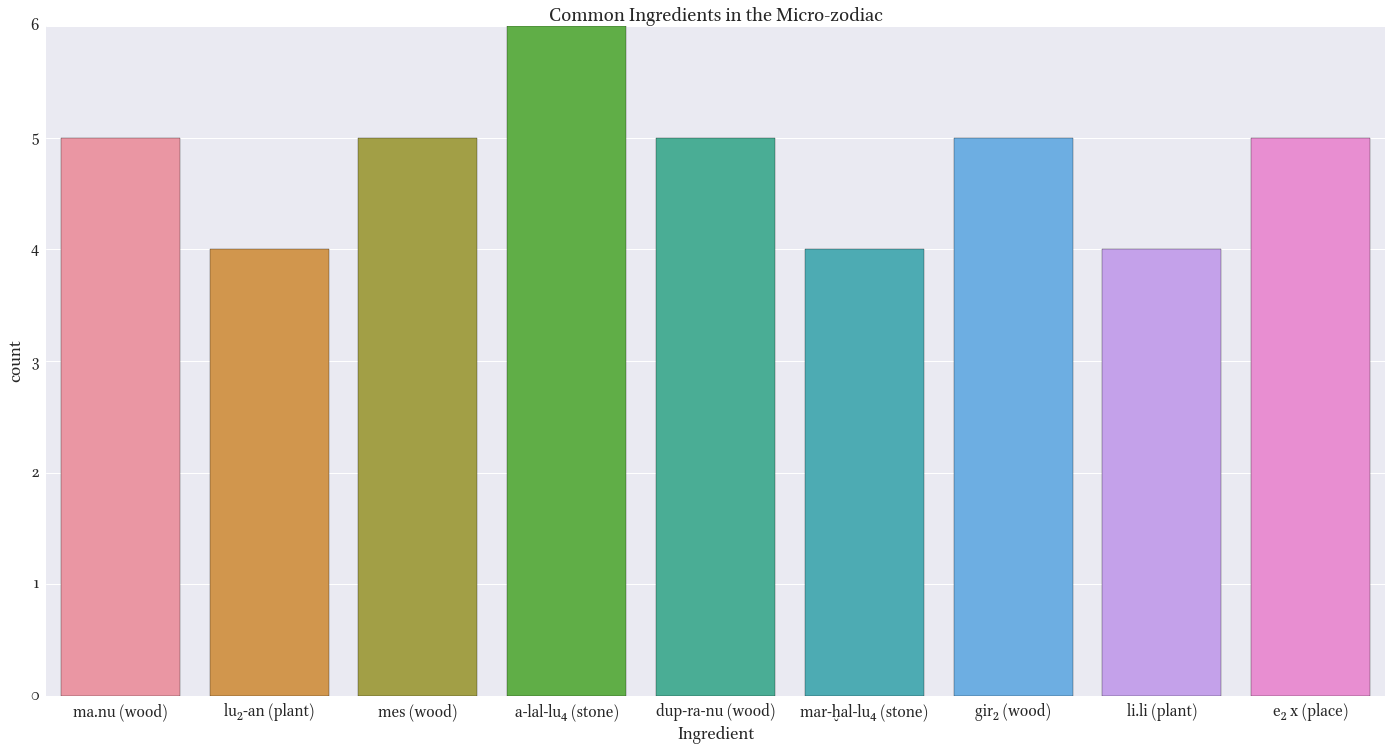

In [9]:
# Plot a simple count of ingredients which occure more than 4 times

mats_over_4 = mz_ingredients.groupby('name_and_type').filter(lambda x: len(x) > 3)['name_and_type']

plt.figure(figsize=(24,12))
ax = sns.countplot(x=mats_over_4)
ax.set(xlabel='Ingredient', title="Common Ingredients in the Micro-zodiac")


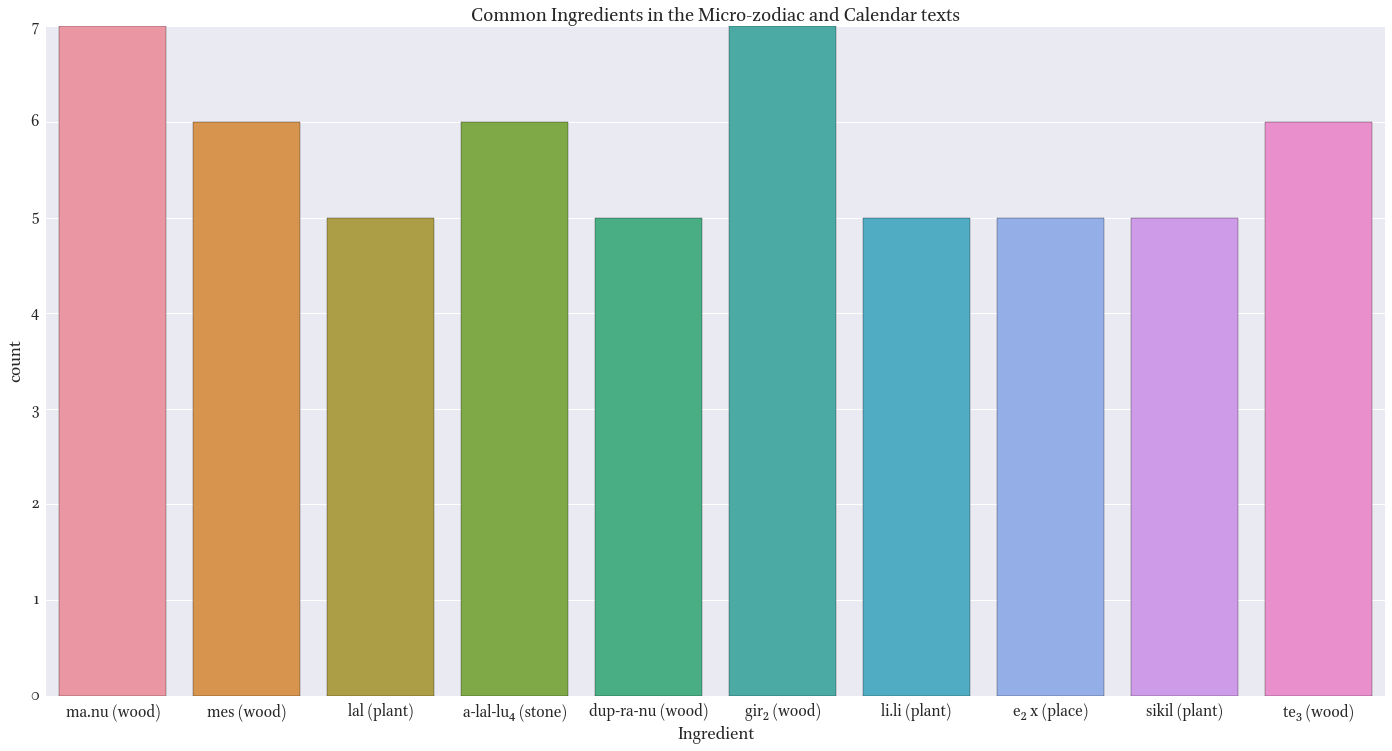

In [10]:
# Plot a simple count of ingredients which occure more than 4 times

mats_over_4 = cleaned_ingredients.groupby('name_and_type').filter(
    lambda x: len(x) > 4)['name_and_type']
#mats_over_4 = mats_over_4[~mats_over_4.isin(['x (0)'])]

plt.figure(figsize=(24,12))
ax = sns.countplot(x=mats_over_4)
ax.set(xlabel='Ingredient', title="Common Ingredients in the Micro-zodiac and Calendar texts")


# Appendix
This section is a further exploration of the data using hierarchical clustering with the results visualized with a dendrogram.

In [11]:
from scipy.cluster.hierarchy import ward, dendrogram

In [12]:
df_bags = make_bags(cleaned_ingredients)
df_dtm = get_adjacency_matrix(df_bags)

In [13]:
link_matrix = ward(df_dtm)

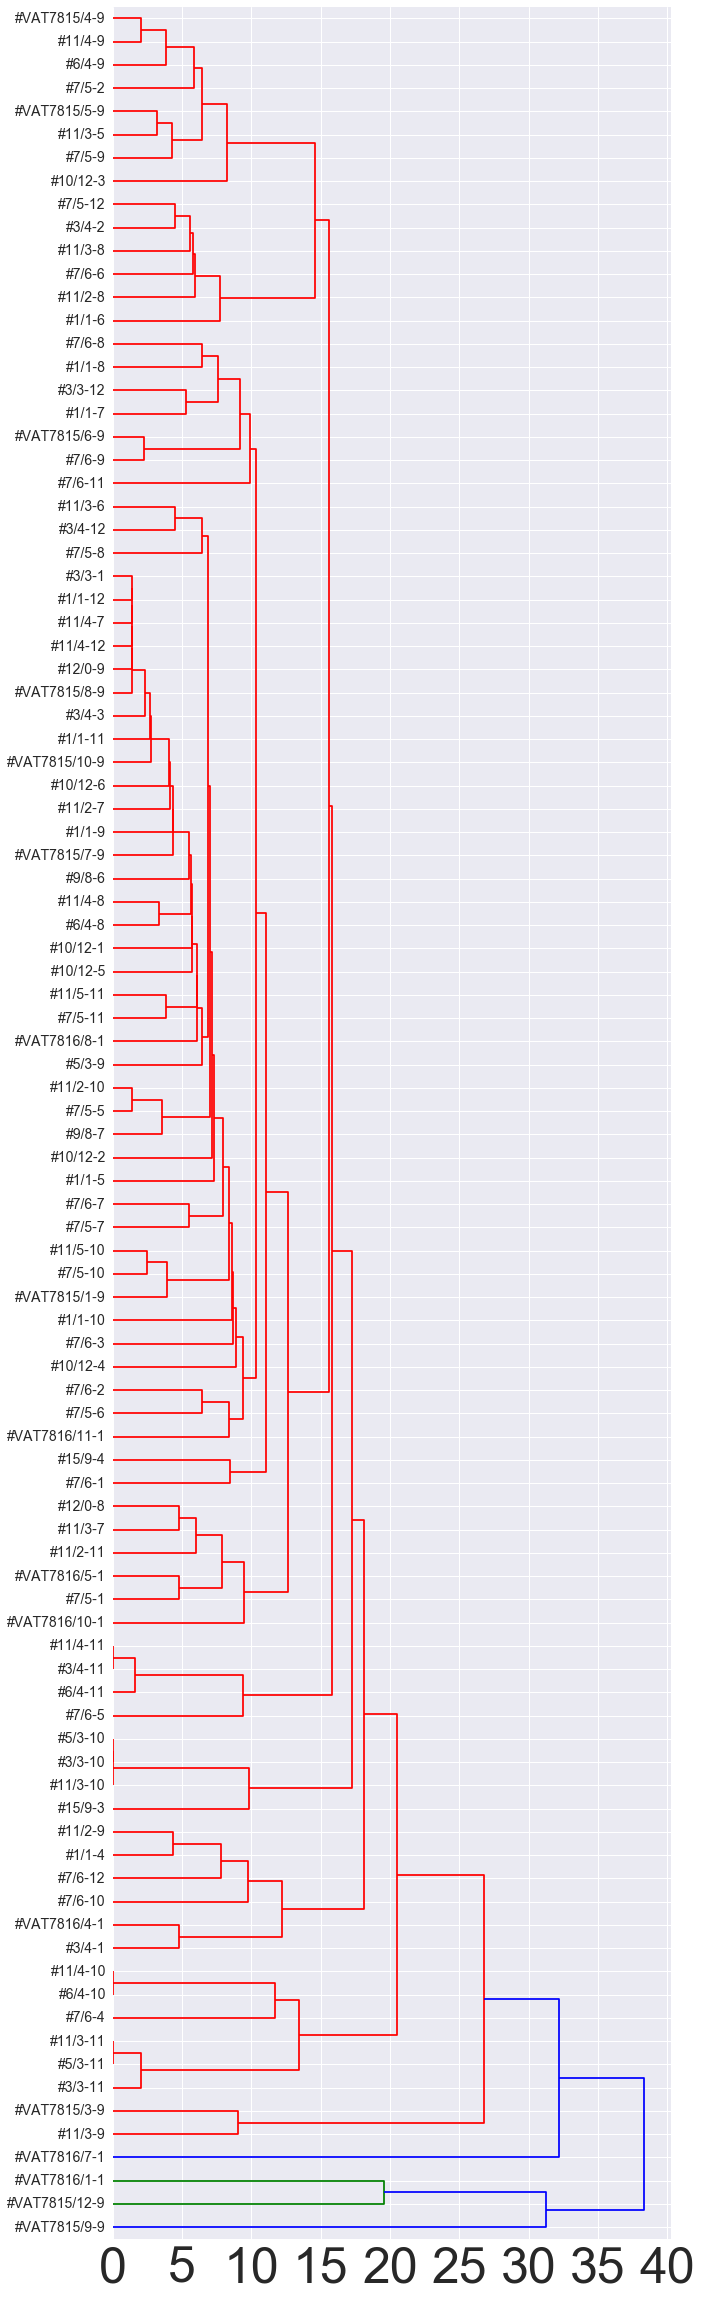

In [33]:
dendrogram(link_matrix, orientation="right", labels=df_bags.index, leaf_font_size=14)
fig = plt.gcf()
fig.set_size_inches(10, 40)
plt.show()